# Multiple Logistic Regression in Spark  - College Admission

### Overview
Predict college admission using Multiple Logistic Regression
 
### Builds on
None

### Run time
approx. 10-20 minutes

### Notes



In [1]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /Users/sujee/spark
Spark config:
	 spark.app.name=TestApp
	spark.master=local[*]
	executor.memory=2g
	spark.sql.warehouse.dir=/var/folders/lp/qm_skljd2hl4xtps5vw0tdgm0000gn/T/tmp0ahn5m18
	some_property=some_value
Spark UI running on port 4040



## Step 1: College Admission Data

Let's look at the college admission data.  Here, we have some student test scores, GPA, and Rank, followed by whether the student was admitted or not.

```
|gre  |gpa  |rank |  admitted |
|-----------------------------|
|380  |3.61 | 3   |    no     |
|660  |3.67 | 1   |    yes    |
|800  |4.0  | 1   |    yes    |
|640  |3.19 | 4   |    yes    |
|520  |2.93 | 4   |    no     |
|760  |3.0  | 2   |    yes    |
```

In [2]:
admissions = spark.read.csv("/data/college-admissions/admission-data.csv",\
                            header=True, inferSchema=True)
admissions.printSchema()
admissions.show()

root
 |-- admit: integer (nullable = true)
 |-- gre: integer (nullable = true)
 |-- gpa: double (nullable = true)
 |-- rank: integer (nullable = true)

+-----+---+----+----+
|admit|gre| gpa|rank|
+-----+---+----+----+
|    0|380|3.61|   3|
|    1|660|3.67|   3|
|    1|800| 4.0|   1|
|    0|640|3.19|   4|
|    0|520|2.93|   4|
|    1|760| 3.0|   2|
|    0|560|2.98|   1|
|    0|400|3.08|   2|
|    0|540|3.39|   3|
|    1|700|3.92|   2|
|    1|800| 4.0|   4|
|    0|440|3.22|   1|
|    1|760| 4.0|   1|
|    1|700|3.08|   2|
|    1|700| 4.0|   1|
|    0|480|3.44|   3|
|    1|780|3.87|   4|
|    0|360|2.56|   3|
|    1|800|3.75|   2|
|    0|540|3.81|   1|
+-----+---+----+----+
only showing top 20 rows



## Basic Exploration

In [3]:
# see the data spread
admissions.groupBy("admit").count().show()

+-----+-----+
|admit|count|
+-----+-----+
|    1|   43|
|    0|   57|
+-----+-----+



In [4]:
## see each column 
admissions.describe().toPandas()

,summary,admit,gre,gpa,rank
0,count,100,100,100,100
1,mean,0.43,600.0,3.390699999999998,2.52
2,stddev,0.49756985195624304,124.46248065545332,0.3971877275408833,1.019803902718557
3,min,0,300,2.42,1
4,max,1,800,4.0,4


## Step 2: Prepare feature vector

We need to firstconvert the dataframe to spark, and then prepare the feature vector.


In [5]:
from pyspark.ml.feature import VectorAssembler

## TODO: Select all columns except for "admit" to be in features **
## Hint : select columns 'gpa', 'gre', 'rank'
assembler = VectorAssembler(inputCols=["gpa", "gre","rank"], outputCol="features")
featureVector = assembler.transform(admissions)

In [6]:
## TODO: Make a new column called "label" with same value as "admit"
## Hint : featureVector is 'admit'
featureVector = featureVector.withColumn("label",featureVector["admit"])
featureVector.show()

+-----+---+----+----+----------------+-----+
|admit|gre| gpa|rank|        features|label|
+-----+---+----+----+----------------+-----+
|    0|380|3.61|   3|[3.61,380.0,3.0]|    0|
|    1|660|3.67|   3|[3.67,660.0,3.0]|    1|
|    1|800| 4.0|   1| [4.0,800.0,1.0]|    1|
|    0|640|3.19|   4|[3.19,640.0,4.0]|    0|
|    0|520|2.93|   4|[2.93,520.0,4.0]|    0|
|    1|760| 3.0|   2| [3.0,760.0,2.0]|    1|
|    0|560|2.98|   1|[2.98,560.0,1.0]|    0|
|    0|400|3.08|   2|[3.08,400.0,2.0]|    0|
|    0|540|3.39|   3|[3.39,540.0,3.0]|    0|
|    1|700|3.92|   2|[3.92,700.0,2.0]|    1|
|    1|800| 4.0|   4| [4.0,800.0,4.0]|    1|
|    0|440|3.22|   1|[3.22,440.0,1.0]|    0|
|    1|760| 4.0|   1| [4.0,760.0,1.0]|    1|
|    1|700|3.08|   2|[3.08,700.0,2.0]|    1|
|    1|700| 4.0|   1| [4.0,700.0,1.0]|    1|
|    0|480|3.44|   3|[3.44,480.0,3.0]|    0|
|    1|780|3.87|   4|[3.87,780.0,4.0]|    1|
|    0|360|2.56|   3|[2.56,360.0,3.0]|    0|
|    1|800|3.75|   2|[3.75,800.0,2.0]|    1|
|    0|540

## Step 3: Split Data into training and Test

We will split our data into training and test so we can see how it performs.

In [7]:
## TODO : Split the data into train and test 70%  and 30%
## Hint : 
##     - training split is 70%  --> 0.7
##     - testing split  is 30%  --> 0.3
(train, test) = featureVector.randomSplit([0.7,  0.3])
#(train, test) = featureVector.randomSplit([???,  ???], seed=1)

## print out record count
print ("train dataset count : " , train.count())
print ("test dataset count : " , test.count())

print("training data set")
train.show(10)

print("test data set")
test.show(10)

train dataset count :  68
test dataset count :  32
training data set
+-----+---+----+----+----------------+-----+
|admit|gre| gpa|rank|        features|label|
+-----+---+----+----+----------------+-----+
|    0|300|2.92|   4|[2.92,300.0,4.0]|    0|
|    0|360|2.56|   3|[2.56,360.0,3.0]|    0|
|    0|360|3.14|   1|[3.14,360.0,1.0]|    0|
|    0|380|2.91|   4|[2.91,380.0,4.0]|    0|
|    0|380|2.94|   3|[2.94,380.0,3.0]|    0|
|    0|400|3.08|   2|[3.08,400.0,2.0]|    0|
|    0|400|3.31|   3|[3.31,400.0,3.0]|    0|
|    0|400|3.35|   3|[3.35,400.0,3.0]|    0|
|    0|440|2.48|   4|[2.48,440.0,4.0]|    0|
|    0|440|3.13|   4|[3.13,440.0,4.0]|    0|
+-----+---+----+----+----------------+-----+
only showing top 10 rows

test data set
+-----+---+----+----+----------------+-----+
|admit|gre| gpa|rank|        features|label|
+-----+---+----+----+----------------+-----+
|    0|380|3.61|   3|[3.61,380.0,3.0]|    0|
|    0|400|3.05|   2|[3.05,400.0,2.0]|    0|
|    0|400|3.65|   2|[3.65,400.0,2.0


## Step 4: Run logistic regression

In [23]:
from pyspark.ml.classification import LogisticRegression

## TODO : set maxIter to 10
#lr = LogisticRegression(maxIter=???)
lr = LogisticRegression(maxIter=100, regParam=0.3, elasticNetParam=0.8)

## TODO : Fit the model on 'training' set
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.0,0.0011316330880945052,0.0]
Intercept: -0.9691725970516694


**==> Q : Do any of your coefficients zero?  What is the implication?**  
If you see ZERO coefficients, try the following:
- increase the number of iterations and run again
- turn off regularization by setting `regparam=0`

## Step 5: Predict on Test data

In [9]:
## TODO : predict on 'test' data
predictions_test = lrModel.transform(test)

predictions_test.show()

# sample a few 0 and 1
predictions_test.sampleBy("prediction", fractions={0: 0.5, 1: 0.5}, seed=0).show()

+-----+---+----+----+----------------+-----+--------------------+--------------------+----------+
|admit|gre| gpa|rank|        features|label|       rawPrediction|         probability|prediction|
+-----+---+----+----+----------------+-----+--------------------+--------------------+----------+
|    0|380|3.61|   3|[3.61,380.0,3.0]|    0|[0.53915202357575...|[0.63161513476859...|       0.0|
|    0|400|3.05|   2|[3.05,400.0,2.0]|    0|[0.51651936181386...|[0.62633351716522...|       0.0|
|    0|400|3.65|   2|[3.65,400.0,2.0]|    0|[0.51651936181386...|[0.62633351716522...|       0.0|
|    0|480|3.57|   2|[3.57,480.0,2.0]|    0|[0.42598871476630...|[0.60491540487727...|       0.0|
|    0|500|2.71|   2|[2.71,500.0,2.0]|    0|[0.40335605300441...|[0.59949372018556...|       0.0|
|    0|500|3.17|   3|[3.17,500.0,3.0]|    0|[0.40335605300441...|[0.59949372018556...|       0.0|
|    0|540|3.12|   1|[3.12,540.0,1.0]|    0|[0.35809072948063...|[0.58857817506059...|       0.0|
|    0|540|3.78|   4

## Step 6: Evaluate Model

In [10]:
trainingSummary = lrModel.summary

predictions_test = lrModel.transform(test)
predictions_train = lrModel.transform(train)

# we can also get this from trainingSummary
predictions_train = lrModel.summary.predictions

### 6.1 - Iterations and Objective History
**==> Q : how many iterations did we do?**  
- What does that tell you?
- Increase the total number of iterations from 50 to 100, Does it change the results?

In [11]:
## trainingSummary has an attribute called 'totalIterations'  
## Hint : use the TAB completion
print ("total iterations ", trainingSummary.totalIterations)

## you can uncomment this and see how the error is diminishing in each iteration
print("objectiveHistory:", trainingSummary.objectiveHistory)
# for objective in trainingSummary.objectiveHistory:
#     print(objective)

total iterations  88
objectiveHistory: [0.6822947159310478, 0.6821308887834129, 0.6821225326810287, 0.6821162861796115, 0.682111086537798, 0.6821053035744814, 0.6820713402390333, 0.6816748119007442, 0.6807247376512062, 0.6806029551512839, 0.680487147373066, 0.6790948884820048, 0.6790918789648982, 0.6790918779808143, 0.6790918687631167, 0.6790918668102437, 0.6790918609329124, 0.6790918586147431, 0.6790918549056303, 0.6790918525684003, 0.6790918502582547, 0.6790918481220051, 0.6790918462695792, 0.6790918453391916, 0.6790918439267083, 0.6790918429078534, 0.6790918420244457, 0.6790918410699438, 0.6790918404911943, 0.679091839659611, 0.6790918392641078, 0.6790918385677173, 0.6790918382875375, 0.6790918377178085, 0.6790918375135059, 0.6790918370540564, 0.6790918369017604, 0.6790918365346043, 0.6790918364192252, 0.6790918361275374, 0.6790918360391146, 0.6790918358082666, 0.6790918357399566, 0.6790918355577149, 0.6790918355046521, 0.6790918353610182, 0.6790918353196457, 0.6790918352065638, 0.6

### 6.2 - Accuracy

In [12]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")

print("Training set accuracy = " , evaluator.evaluate(predictions_train))
print("Test set accuracy = " , evaluator.evaluate(predictions_test))

Training set accuracy =  0.5735294117647058
Test set accuracy =  0.5625


### 6.3 Confusion Matrix

In [13]:
cm = predictions_test.groupBy('admit').pivot('prediction').count().na.fill(0).orderBy('admit')
cm.show()

+-----+---+
|admit|0.0|
+-----+---+
|    0| 18|
|    1| 14|
+-----+---+



In [14]:
import seaborn as sns

cm_pd = cm.toPandas()
cm_pd.set_index("admit", inplace=True)
# print(cm_pd)

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm_pd, annot=True, cmap="Blues").plot()

[]

### 6.4 :  ROC Curve & AUC

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# default metrics for BinaryClassificationEvaluator is 'areaUnderCurve'
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
# print ("default metrics : " ,evaluator.getMetricName())

# we can get this from trainingSummary
print("AUC for training: " , trainingSummary.areaUnderROC)
# or
print("AUC for training: " , evaluator.evaluate(predictions_train))
print ("AUC for test : " , evaluator.evaluate(predictions_test))

AUC for training:  0.8368700265251989
AUC for training:  0.8368700265251989
AUC for test :  0.9067460317460319


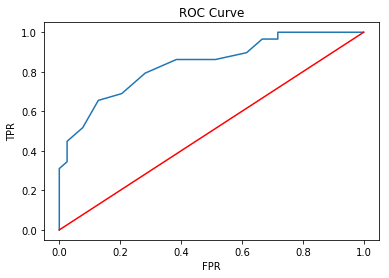

In [16]:
# ROC for training

%matplotlib inline
import matplotlib.pyplot as plt

roc_df = trainingSummary.roc.toPandas()

plt.plot(roc_df['FPR'], roc_df['TPR'])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.plot([0.0, 1.0], [0.0, 1.0], 'r')

## Step 7: Run some predictions on new data

Let's take some new data, and run predictions on that.


In [17]:
import pandas as pd

newdata = pd.DataFrame({'gre' : [600, 700, 800], 
                        'gpa' : [4.0, 3.5, 3.2],
                        'rank': [1,   2,   3]}
             )
print(newdata)


## TODO: create spark dataframe from pandas dataframe
## Hint : input is 'newdata'
spark_newdata = spark.createDataFrame(newdata)

## TODO: transform the new data in order to get feature vectors
## Hint : spark_newdata
newfeatures = assembler.transform(spark_newdata)

lrModel.transform(newfeatures).show()

   gre  gpa  rank
0  600  4.0     1
1  700  3.5     2
2  800  3.2     3
+---+---+----+---------------+--------------------+--------------------+----------+
|gre|gpa|rank|       features|       rawPrediction|         probability|prediction|
+---+---+----+---------------+--------------------+--------------------+----------+
|600|4.0|   1|[4.0,600.0,1.0]|[0.29019274419496...|[0.57204331924673...|       0.0|
|700|3.5|   2|[3.5,700.0,2.0]|[0.17702943538551...|[0.54414213659935...|       0.0|
|800|3.2|   3|[3.2,800.0,3.0]|[0.06386612657606...|[0.51596110672339...|       0.0|
+---+---+----+---------------+--------------------+--------------------+----------+



## Step 8: Experiment
Click on 'Cell --> RunAll' and watch the accuracy number below.  
See how it changes?  
Can you explain why?

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")

print("Training set accuracy = " , evaluator.evaluate(predictions_train))
print("Test set accuracy = " , evaluator.evaluate(predictions_test))

Training set accuracy =  0.5735294117647058
Test set accuracy =  0.5625


### 8.1 - Why do you think the accuracy varies for each run?  

Try this, at Step-3, supply a seed parameter (can be any number) and do the run again.  
Do you see the accuracy varying now?  
Can you explain the behavior?

### 8.2 - Adjust regularization (lambda) parameter
Vary 'regparam' in **step 4** from 0.0 to 0.9.  
Do you see accuracy changing?

### 8.3 - Set threshold
We can setup 'threshold' in Step-4, as follows

```python
lr = LogisticRegression(maxIter=???, regParam=0.3, elasticNetParam=0.8)
lr.threshold = 0.7  # values between 0 and 1.0
```

Change the threshold and try a few runs.  See how the accuracy changes.

### 8.4 - Class discussion
How do you find the right 'lambda' ..etc values?  
Hint : lots of experimental runs :-) 

## Step 9 : Save Output
**TODO : Inspect the saved data**  
(Hint : you can open them in excel)

In [19]:
# save data to a csv file for inspection
predictions2 = predictions_test.select(['admit', 'gre', 'gpa', 'rank', 'prediction'])

## option1 : use Spark write function
## this works for big data (writes are distributed across cluster)
output_path1="college-admissions-predictions.out1"
predictions2.write.\
    option('header', 'true').\
    mode('overwrite').\
    csv(output_path1)
print("save 1 (spark)  to : ", output_path1)


## Option 2 : convert to Pandas dataframe and save
## This is good for small amount of data
output_path2= 'college-admissions-predictions.out2.csv'
predictions2.toPandas().to_csv(output_path2 )
print("save 2 (pandas) to : ", output_path2)

save 1 (spark)  to :  college-admissions-predictions.out1
save 2 (pandas) to :  college-admissions-predictions.out2.csv
